In [0]:
###  Rer.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
##-- import library
import numpy as np 
import pandas as pd 
##-- Scikit-Learn
from sklearn.model_selection import train_test_split
##-- Matplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools

import pickle
sns.set(style='white', context='notebook', palette='deep')

In [1]:
##-- Updata tensorflow 1.x -->  2.x
!pip install tensorflow-gpu 
!pip install tf-nightly 

In [0]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.backend.floatx())
print(tf.test.gpu_device_name())

2.1.0-dev20200110
float32
/device:GPU:0


In [0]:
###-- データの読みこみ --###

import numpy as np
import os

class UkiyoeDataLoader(object):
    """
    Example
    -------
    >>> ukiyoe_dl = UkiyoeDataLoader()
    >>> datapath = "./data"
    >>> train_imgs, train_lbls, validation_imgs, validation_lbls = ukiyoe_dl.load(datapath)
    """
    def __init__(self, validation_size: float):
        """
        validation_size : float
        [0., 1.]
        ratio of validation data
        """
        self._basename_list = [
        'ukiyoe-train-imgs.npz',\
        'ukiyoe-train-labels.npz'
        ]
        self.validation_size = validation_size

    def load(self, datapath: str, random_seed: int=13) -> np.ndarray:
        filenames_list = self._make_filenames(datapath)
        data_list = [np.load(filename)['arr_0'] for filename in filenames_list]

        all_imgs, all_lbls = data_list
        ##########################################
        ##########################################
        # shuffle data
        from sklearn.utils import shuffle
        all_imgs, all_lbls = shuffle(all_imgs, all_lbls, random_state=20191231)
        ##########################################
        ##########################################

        # shuffle data
        np.random.seed(random_seed)
        perm_idx = np.random.permutation(len(all_imgs))
        all_imgs = all_imgs[perm_idx]
        all_lbls = all_lbls[perm_idx]

        # split train and validation
        validation_num = int(len(all_lbls)*self.validation_size)

        validation_imgs = all_imgs[:validation_num]
        validation_lbls = all_lbls[:validation_num]

        train_imgs = all_imgs[validation_num:]
        train_lbls = all_lbls[validation_num:]

        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _make_filenames(self, datapath: str) -> list:
        filenames_list = [os.path.join(datapath, basename) for basename in self._basename_list]
        return filenames_list

In [0]:
from tensorflow.keras import layers, models

In [0]:
###-- 分類する数 --###
num_classes = 10

###---  読み込み  ---###
datapath = "drive/My Drive/data/"

# ###--検証用データの比率
validation_size = 0.2
###-- 全体の20%をテスト用に割り当てる
X_train, Y_train, X_test, Y_test \
= UkiyoeDataLoader(validation_size).load(datapath)
X_test = X_test.astype(np.float32)
X_test = np.multiply(X_test, 1.0 / 255.0)
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_test = to_categorical(Y_test, num_classes = 10)

###--型をint --> float変換する。
X_train = X_train.astype(np.float32)
###-- convert from [0:255] => [0.0:1.0]
X_train = np.multiply(X_train, 1.0 / 255.0)

###-- Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)


print(X_train.shape)

Using TensorFlow backend.


(2527, 224, 224, 3)


In [2]:
print(Y_train[0])
print(X_train[3][0].shape)
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[22], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
"""
    Cutout Random Erasing
"""
###-- Rondom Erasing --###
def eraser(input_img):
    ##-- Parameter
    p=0.5
    s_l=0.02
    s_h=0.4
    r_1=0.3
    r_2=1/0.3
    v_l=0
#     v_h=255
    v_h=1
    pixel_level=False
    ##--
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img
  

"""
    Batch dealing of Random Erasing
"""
def RandomErase( img_train ):
  x = []
  for i in range( len(img_train) ):
    tem = eraser( img_train[i] )
    x.append( tem )
    
  x = np.array(x)
  
  return x

In [0]:
###-- Cutout Random Erasing --##
X_train = RandomErase( X_train )
print( X_train.shape )

(2527, 224, 224, 3)


In [3]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[22], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
"""
    Data Augmentation
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import randint

##--(Number of data, Height, Width, Channels) 
def Data_Augmentation(image):
  """
      Set augmentation generator
  """
  ##-- Rondom flip
  rotation = ImageDataGenerator(rotation_range=20)
  ##-- Parallel Movement align to vertical direction.
  shift_vertical = ImageDataGenerator(height_shift_range=0.2)
  ##-- Parallel Movement align to horizontal direction.
  shift_horizontal = ImageDataGenerator(width_shift_range=0.2)
  ##-- Shear transformation; shera_range describes "angle".
  shear = ImageDataGenerator(shear_range=5)
  ##-- [-5.0, 5.0] の範囲でランダムに画素値に値を足す。
  noise = ImageDataGenerator(channel_shift_range=5.)
  ##-- [0.3, 1.0] の範囲でランダムに明度を変更する。
  brightness = ImageDataGenerator(brightness_range=[0.3, 1.0])
  ##--
  ret = []
  for i in range( 0, len(image) ):
    tem_img = np.reshape(image[i], [-1, image[i].shape[0], image[i].shape[1], image[i].shape[2]])
    ##-- Create random number between 0 - 3.
    rand_int = randint(4)
    if rand_int == 0:
      img_rot = rotation.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 1:
      img_rot = shift_vertical.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 2:
      img_rot = shift_horizontal.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 3:
      img_rot = shear.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = noise.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 5:
    #   img_rot = brightness.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = tem_img
    # #--
    # img_rot = next(img_rot)
    # #--
    ret.append( img_rot[0] )

  ret = np.array( ret )
  
  return ret

In [0]:
"""
    Data Augmentation and Inflation
"""
import gc

multiple = 1
img_ori = X_train.copy()
lbl_ori = Y_train.copy()
for i in range( multiple ):
  data_tem = Data_Augmentation( img_ori )
  X_train = np.append( X_train, data_tem, axis=0 )
  Y_train = np.append( Y_train, lbl_ori, axis=0 )

del img_ori, lbl_ori
gc.collect()

print(X_train.shape)
print(Y_train.shape)

(5054, 224, 224, 3)
(5054, 10)


In [4]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[3050], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-- Shuffle dataset --###
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=20191231)

###---  Definition of each Model  ---###

学習およびモデルの保存

In [0]:
"""
    Baseline model
"""
def swish( x, beta=1. ):
  return x*K.sigmoid(beta*x)

activation = "relu"
# activation = "swish"  #--NOT good
# activation = "elu"  #--NOT good

def baseline_model(_input_shape, num_classes=10):
    # Model
    model = models.Sequential()
    # Add convolution 2D
    model.add(layers.Conv2D(32, kernel_size=(3, 3),activation=activation, padding="same",
            kernel_initializer='he_normal',input_shape=_input_shape))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32,kernel_size=(3, 3), activation=activation))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same',activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    # Add dropouts to the model
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation=activation))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, 
                           activation=activation, 
                           ))
    # Add dropouts to the model
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation=activation))

    return model


In [0]:
##-- Select the Model
model = baseline_model(_input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 55, 55, 32)        1

In [2]:
##-- Define the optimizer
from tensorflow.keras import optimizers, losses
optimizer = optimizers.SGD(lr = 0.005, #--lr=0.01
                           momentum = 0.9, #--Default: 0.9
                           nesterov = True #--Default: False
                           )
# optimizer = optimizers.Adam(lr=0.001,
#                             beta_1=0.9, beta_2=0.999, #--Defoalt values
#                             amsgrad=True, #--AMSGrad
#                             )
##-- Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 100
batch_size = 64 #-- Default: 128, 64, 32
##-- Early stopping as es
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
##-- Run
history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_test,Y_test), #-- validation_split=0.2
                    verbose=2, 
                    # callbacks = [es]
                    )

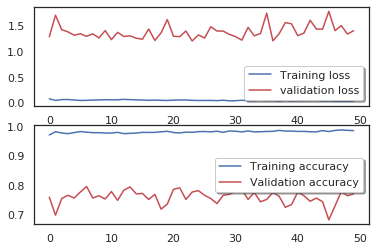

In [0]:
 # Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

テストデータで予測

In [0]:
###---  提出用データの読み込み  ---###

###--データの読み込み
def load(f):
    return np.load(f)['arr_0']
X_submit = load(datapath+"ukiyoe-test-imgs.npz")

###--型をint --> float変換する。
X_submit = X_submit.astype(np.float32)
###-- convert from [0:255] => [0.0:1.0]
X_submit = np.multiply(X_submit, 1.0 / 255.0)

print(X_submit.shape)

(397, 224, 224, 3)


In [0]:
###---  Prediction  ---###
predicts = np.argmax(model.predict(X_submit), axis=1)
predicts.shape

(397,)

In [1]:
###---  提出ファイル作成  ---###
submit = pd.DataFrame(data={"id": [], "y": []})
submit.id = list(range(1, predicts.shape[0]+1))
submit.y = predicts
submit.to_csv("submit.csv", index=False)

from google.colab import files
files.download("submit.csv")